# BattDiag Demo: Battery Diagnostics Functions

This notebook demonstrates the usage of BattDiag for battery cell diagnostics.

## Contents
1. Load sample data
2. Apply fault signal calculations
3. Visualization

## Environment Setup

The following imports provide all necessary tools for this analysis:
- **NumPy & Pandas**: Data manipulation and analysis
- **Matplotlib**: Visualization
- **BattDiag**: The battery diagnostics functions

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt

# Import BattDiag modules
from  battdiag import cellEval, crossCellEval

## 1. Load Sample Data

The sample dataset contains voltage measurements from 12 battery cells over time.

In [2]:
# Fault paramaters known from data generation
fault_metadata = {
    'faultyCell': 1,  # Index of the faulty cell (1-based)
    'tFault': 900,  # Time of fault occurrence in seconds
    'faultDuration': 30,  # Duration of the fault in seconds
    'R_fault' : 1 # Resistance of the fault in Ohms
}

# Load data
df = pd.read_csv('sample_data.csv', sep=',',  decimal='.', index_col=0)
df.index = pd.to_timedelta(df.index)
df.head()

,U_01_V,U_02_V,U_03_V,U_04_V,U_05_V,U_06_V,U_07_V,U_08_V,U_09_V,U_10_V,U_11_V,U_12_V,I_A
Time_s,,,,,,,,,,,,,
0 days 00:00:00,3.997497,3.997897,3.998650,3.997307,3.997455,3.997132,3.997234,3.996157,3.998094,3.995987,3.996312,3.998613,-0.0
0 days 00:00:00.100000,3.997043,3.997989,3.997621,3.995891,3.997789,3.998701,3.996983,3.997511,3.997711,3.997958,3.997080,3.997069,-0.0
0 days 00:00:00.200000,3.997046,3.997345,3.995910,3.998991,3.998295,3.996862,3.996863,3.997177,3.998456,3.996471,3.998386,3.998483,-0.0
0 days 00:00:00.300000,3.998346,3.998979,3.997311,3.998396,3.998051,3.998020,3.995736,3.996661,3.996815,3.998659,3.996185,3.997084,-0.0
0 days 00:00:00.400000,3.998696,3.998619,3.996460,3.995531,3.997972,3.996893,3.998931,3.998729,3.996141,3.998465,3.998804,3.998778,-0.0


Data shape: (12001, 13)
Time range: 0.0 - 1200.0 s


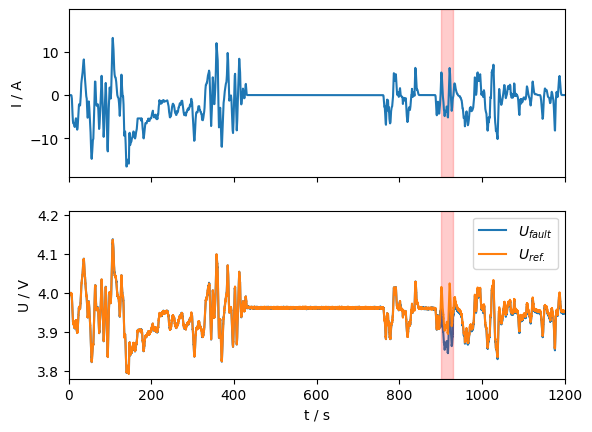

In [11]:
# Extract voltage data (shape: T x N)
print(f"Data shape: {df.shape}")
print(f"Time range: {df.index.total_seconds()[0]:.1f} - {df.index.total_seconds()[-1]:.1f} s")

# Plot raw data
plt.close('all')
fig, axes = plt.subplots(2,1, sharex = 'col')
ax1,ax2 = axes
ax1.plot(df.index.total_seconds(), df['I_A'])
ax2.plot(df.index.total_seconds(), df['U_01_V'], zorder=1, label=r'$U_{fault}$')
ax2.plot(df.index.total_seconds(), df['U_02_V'], zorder=2, label=r'$U_{ref.}$')
ax1.set_ylabel("I / A")
ax2.set_ylabel(r"U / V")
ax2.set_xlabel(r"t / s")
ax2.set_xlim(0,1200)
ax2.legend(loc='upper right')


# Highlight fault period
tstart = fault_metadata['tFault']
tend = fault_metadata['tFault'] + fault_metadata['faultDuration']
ax1.axvspan(tstart, tend, color="red", alpha = 0.2)
ax2.axvspan(tstart, tend, color="red", alpha = 0.2)
ax1.set_ylim(-19,19.9)
ax2.set_ylim(3.78, 4.21)

fig.savefig("figures/raw_data_demo.png", dpi=300)

### Data Exploration

This WLTC-based test case includes:
- **Dynamic load segments**: Realistic driving cycle profiles that challenge battery monitoring
- **Rest phases**: Noise-dominated segments
- **Internal short circuit (ISC) fault**: $R_\mathrm{ISC} = 1\Omega$, duration 30s 
  - Voltage signature change is subtle but detectable with appropriate algorithms

The raw voltage traces show cell-to-cell variation typical of real battery packs. The fault event should manifest as anomalies in the diagnostic metrics we calculate below.

## Apply fault signal calculation

In [4]:
from numba.typed import List

data = df[[c for c in df.columns if 'U_' in c]].values
zScore = cellEval.numba_rolling_avgZscore(data, 100,8, preProcessing="None", preParameters=List([10.0]),  midProcessing = "None", midParameters=List([0.1,2.0]), postProcessing="None", postParameters=List([1.0]))
pearCorr =crossCellEval.numba_rolling_PearCorr(data, 100,8, preProcessing="None", preParameters=List([10.0]),  midProcessing = "None", midParameters=List([0.1,2.0]), postProcessing="zScore", postParameters=List([1.0]))
LOF=cellEval.rolling_LOF(data, 100, accuracy=8, neighbors=10, preProcessing="None", preParameters=List([10.0]),  midProcessing = "None", midParameters=List([0.1,2.0]), postProcessing="None", postParameters=List([1.0]))
LoOP=cellEval.rolling_LoOP(data, 100, accuracy=8, neighbors=10, preProcessing="None", preParameters=List([10.0]),  midProcessing = "None", midParameters=List([0.1,2.0]), postProcessing="None", postParameters=List([1.0]))

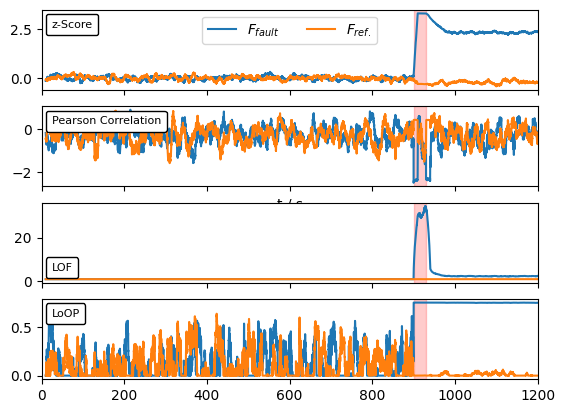

In [8]:
from matplotlib.offsetbox import AnchoredText
def set_subplot_title(ax, title, loc='upper left'):
    at = AnchoredText(title, prop=dict(size=8), frameon=True, loc=loc)
    at.patch.set_boxstyle("round,pad=0.1,rounding_size=0.2")
    ax.add_artist(at)

# Plot fault signal  data
plt.close('all')
fig, axes = plt.subplots(4,1, sharex = 'col')
ax1,ax2, ax3, ax4 = axes

ax1.plot(df.index.total_seconds(), zScore[:,0], label=r'$F_{fault}$')
ax1.plot(df.index.total_seconds(), zScore[:,1], label=r'$F_{ref.}$')
ax1.legend(loc='upper center', ncols=2)
set_subplot_title(ax1, "z-Score")

ax2.plot(df.index.total_seconds(), pearCorr[:,0,1])
ax2.plot(df.index.total_seconds(), pearCorr[:,1,2])
set_subplot_title(ax2, "Pearson Correlation")

ax3.plot(df.index.total_seconds(), LOF[:,0])
ax3.plot(df.index.total_seconds(), LOF[:,1])
set_subplot_title(ax3, "LOF", loc='lower left')

ax4.plot(df.index.total_seconds(), LoOP[:,0])
ax4.plot(df.index.total_seconds(), LoOP[:,1])
set_subplot_title(ax4, "LoOP")


ax2.set_xlabel(r"t / s")
ax2.set_xlim(0,1200)

tstart = fault_metadata['tFault']
tend = fault_metadata['tFault'] + fault_metadata['faultDuration']

for ax in axes:
    ax.axvspan(tstart, tend, color="red", alpha = 0.2)

fig.savefig("figures/fault_signal_demo.png", dpi=300)

## Visualization

Example shows the good amplification of the fault signal due to the investigated algorithms. 
